# Init

In [1]:
import sys
print( sys.version )

3.9.18 (main, Aug 25 2023, 13:20:14) 
[GCC 11.4.0]


In [2]:
from ultralytics import YOLO
from PIL import Image

import matplotlib.pyplot as plt
import cv2
import open3d as o3d
import spatialmath as sm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Segmentation

In [3]:
import pyrealsense2 as rs
import numpy as np

In [4]:
class DepthCam:
    """ Simplest possible wrapper around D405 """
    
    def __init__( self, width = 1280, height = 720, zMax=0.5 ):
        """ Open and store a stream """

        self.rows = height
        self.cols = width
        self.zMax = zMax  # max distance for objects in depth images (m)
        self.extrinsics = np.eye(4)  # extrinsic parameters of the camera frame 4 x 4 numpy array
        
        # Create a context object. This object owns the handles to all connected realsense devices
        rs.align( rs.stream.color )
        self.pipeline = rs.pipeline()

        # Configure streams
        self.config = rs.config()
        self.config.enable_stream(rs.stream.depth, width, height, rs.format.z16, 30)
        print( "Depth stream started!" )
        self.config.enable_stream(rs.stream.color, width, height, rs.format.rgb8, 30)
        print( "Color stream started!" )

        # Getting information about the connected realsense model (device object) - D405
        pipeProfile = self.config.resolve( rs.pipeline_wrapper( self.pipeline ) )
        device = pipeProfile.get_device()
        depth_sensor = device.first_depth_sensor()
        self.depthScale = depth_sensor.get_depth_scale()
        
        # Start streaming
        self.pipeline.start( self.config )

        
    def get_frames( self ):
        frames = None
        while not frames:
            frames = self.pipeline.wait_for_frames()
        return frames

    def get_depth_image( self ):
        """ Get one depth frame """
        return np.asanyarray( self.get_frames().get_depth_frame().get_data() )

    def get_pinhole_instrinsics(self, frame):
        # frame is a subclass of pyrealsense2.video_frame (depth_frame,etc)
        intrinsics = frame.profile.as_video_stream_profile().intrinsics
        return o3d.camera.PinholeCameraIntrinsic(intrinsics.width, intrinsics.height, intrinsics.fx,
                                                 intrinsics.fy, intrinsics.ppx,
                                                 intrinsics.ppy)
    
    def take_images( self, save = False ):
        # Takes RGBD Image using Realsense
        # intrinsic and extrinsic parameters are NOT applied only in get_PCD()
        # out: Open3D RGBDImage
        pipe, config = self.pipeline, self.config

        frames = pipe.wait_for_frames()
        depthFrame = frames.get_depth_frame()  # pyrealsense2.depth_frame
        colorFrame = frames.get_color_frame()

        # Sets class value for intrinsic pinhole parameters
        self.pinholeInstrinsics = self.get_pinhole_instrinsics(colorFrame)
        # asign extrinsics here if the camera pose is known
        # alignOperator maps depth frames to color frames
        alignOperator = rs.align(rs.stream.color)
        alignOperator.process(frames)
        alignedDepthFrame, alignedColorFrame = frames.get_depth_frame(), frames.get_color_frame()

        # unmodified rgb and z images as numpy arrays of 3 and 1 channels
        rawColorImage = np.array(alignedColorFrame.get_data())
        rawDepthImage = np.asarray(alignedDepthFrame.get_data())

        rawRGBDImage = o3d.geometry.RGBDImage.create_from_color_and_depth(
            o3d.geometry.Image(rawColorImage),
            o3d.geometry.Image(rawDepthImage.astype('uint16')),
            depth_scale=1.0 / self.depthScale,
            depth_trunc=self.zMax,
            convert_rgb_to_intensity=False)

        if save:
            subFix = str(time.time())
            np.save(f"depthImage{subFix}", rawRGBDImage.depth)
            np.save(f"colorImage{subFix}", rawRGBDImage.color)
            colorIM = Image.fromarray(rawColorImage)
            colorIM.save(f"colorImage{subFix}.jpeg")
        return rawRGBDImage

    def get_PCD( self, save = False ):
        # Takes images and returns a PCD and RGBD Image
        # Applies extrinsics and zMax
        # Downsamples PCD based on self.voxelSize
        # :save boolean that toggles whether to save data
        # out: tuple of (open3d point cloud (o3d.geometry.PointCloud),RGBDImage)
        rawRGBDImage = self.take_images()
        pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
            rawRGBDImage,
            self.pinholeInstrinsics,
            project_valid_depth_only=True,
            extrinsic=self.extrinsics
        )

        # Don't downsample
        # downsampledPCD = pcd.voxel_down_sample(voxel_size=self.voxelSize)
        if save:
            subFix = time.time()
            np.save(f"colorImage{subFix}", np.array(rawRGBDImage.color))
            np.save(f"depthImage{subFix}", np.array(rawRGBDImage.depth))
            o3d.io.write_point_cloud(f"pcd{subFix}.pcd", downsampledPCD)
        return pcd, rawRGBDImage
        # return (downsampledPCD,rawRGBDImage)

    def get_color_pc( self ):
        frames = self.get_frames()
        depFrm = frames.get_depth_frame()
        colFrm = frames.get_color_frame()
        colImg = np.asarray( colFrm.get_data() )
        print( colImg.shape )
        print( colImg[0,0,:] )
        
        pc = rs.pointcloud()
        pc.map_to( colFrm )
        points = pc.calculate( depFrm )
        vtx = np.asarray( points.get_vertices(2) )
        tex = np.asarray( points.get_texture_coordinates(2) )
        col = np.zeros( (vtx.shape[0], 3), dtype = int )

        for k, uvCoord in enumerate( tex ):
            i = int( min( uvCoord[0], 1.0) * (self.cols-1) )
            j = int( -uvCoord[1] * (self.rows-1) )
            print( uvCoord, i ,j )
            col[k,:] = colImg[j,i,:]

        return vtx, col

    def stop( self ):
        """ Stop camera and release resources """
        self.pipeline.stop()

In [5]:
import Block as bl

In [6]:
class ObjectDetection:
    # This class creates a RealSense Object, takes images and returns Open3D point clouds corresponding to blocks
    # Extrinsics of RealSense Object are no longer used here so interfacing with the Realsense could be done outside this class for decoupling
    # Additionally, migration of world and gripper frame position to block objects means moveRelative can also be removed
    def __init__(self, RealSense, robot_model, moveRelative=True):
        # :RealSense - RealSense object
        # :moveRelative boolean - True if the gripper moves to block positions in the camera frame, false if moving to world frame positions (via rtb_model)
        # robot_model is object of type RTB_Model
        self.real = RealSense
        '''
        # self.real.initConnection()
        if moveRelative:
            t = np.array([0,9,59.3]) / 1000
            R = np.array([[0,1,0],[-1,0,0],[0,0,1]])
            camera_frame_transform = sm.SE3.Rt(R,t)
            self.real.cameraFrameTransform = np.array(camera_frame_transform)
            # print(f"Camera Frame Transform:\n{self.real.cameraFrameTransform}")
            self.real.extrinsics = np.array(camera_frame_transform.inv())
            # print(f"Extrinsics:\n{self.real.extrinsics}")
        else:
            T_C = robot_model.getCameraFrame()
            print(T_C)
            self.real.cameraFrameTransform = np.array(T_C)
            self.real.extrinsics = np.array(T_C.inv())
        '''
        # Load the model into memory
        # Trained on yolov8l-seg for 200 epochs
        # yolo models compared https://docs.ultralytics.com/tasks/segment/
        self.model = YOLO('yolov8l-seg.pt')

    def getSegmentationMask(self, result, className):
        # :result ultralytics.result
        # :className string corresponding to label in trained YOLO model
        # Here, className should be in {'Red','Yellow','Blue'}
        # Returns 1st instance of the class as binary numpy array and None if the class is not present
        classList = list(np.array(result.cpu().boxes.cls))
        for i in range(0, len(classList)):
            predictedClassName = result.names[classList[i]]
            if predictedClassName == className:
                mask = result.masks.data[i].cpu().numpy()  # (384,640)
                # Resize mask to original imae size
                scaledMask = cv2.resize(mask, (result.orig_shape[1], result.orig_shape[0]))
                return scaledMask
        return None

    def getBlocksFromImages(self, colorImage, depthImage, urPose, display=False):
        # :colorImage 3-channel rgb image as numpy array
        # :depthImage 1-channel of measurements in z-axis as numpy array
        # :display boolean that toggles whether masks should be shown with color image
        # :urPose 4x4 numpy array or SE3 transform that is the pose of the Nth frame when the images were taken
        # colorImage,depthImage = RGBD_Image.color,RGBD_Image.depth
        # Returns a tuple of (RedPCD,yellowPCD,bluePCD) corresponding to each block class

        # Detects and segments classes using trained yolov8l-seg model
        # Inference step, only return instances with confidence > 0.6
        pilImage = Image.fromarray(np.array(colorImage))
        result = self.model.predict(pilImage, conf=0.6, save=True)[0]

        redMask = self.getSegmentationMask(result, 'Red')
        yellowMask = self.getSegmentationMask(result, 'Yellow')
        blueMask = self.getSegmentationMask(result, 'Blue')

        '''
        if display:
            print("Color Image")
            plt.imshow(colorImage)
            plt.show()
            print("Red Mask")
            plt.imshow(redMask * 255,cmap = 'gray')
            plt.show()
            print("Yellow Mask")
            plt.imshow(yellowMask * 255,cmap = 'gray')
            plt.show()
            print("Blue Mask")
            plt.imshow(blueMask * 255, cmap = 'gray')
            plt.show()
        '''
        if display:
            fig, ax = plt.subplots(2, 1)
            print("Color Image and Depth Image")
            ax[0].imshow(colorImage)
            ax[0].set_title("Color Image")
            ax[1].imshow(depthImage)
            ax[1].set_title("Depth Image")
            plt.show()

            print("Masks")
            fig, ax = plt.subplots(3, 1)
            ax[0].imshow(redMask * 255, cmap='gray')
            ax[0].set_title("Red Mask")
            ax[1].imshow(yellowMask * 255, cmap='gray')
            ax[1].set_title("Yellow Mask")
            ax[2].imshow(blueMask * 255, cmap='gray')
            ax[2].set_title("Blue Mask")
            plt.show()

        redDepthImage = np.multiply(depthImage, redMask.astype(int)).astype('float32')
        yellowDepthImage = np.multiply(depthImage, yellowMask.astype(int)).astype('float32')
        blueDepthImage = np.multiply(depthImage, blueMask.astype(int)).astype('float32')

        # SEGMENT PCD INTO RED,YELLOW,BLUE BLOCKS
        depthScale = self.real.depthScale

        # Create Segmented RGBD Images for Each Color
        redRGDB_Image = o3d.geometry.RGBDImage.create_from_color_and_depth(
            o3d.geometry.Image(colorImage),
            o3d.geometry.Image(redDepthImage),
            convert_rgb_to_intensity=False,
            depth_scale=1
        )

        yellowRGDB_Image = o3d.geometry.RGBDImage.create_from_color_and_depth(
            o3d.geometry.Image(colorImage),
            o3d.geometry.Image(yellowDepthImage),
            convert_rgb_to_intensity=False,
            depth_scale=1
        )

        blueRGBD_Image = o3d.geometry.RGBDImage.create_from_color_and_depth(
            o3d.geometry.Image(colorImage),
            o3d.geometry.Image(blueDepthImage),
            convert_rgb_to_intensity=False,
            depth_scale=1
        )

        # Create Point Clouds for Each Class
        redPCD = o3d.geometry.PointCloud.create_from_rgbd_image(
            redRGDB_Image,
            self.real.pinholeInstrinsics,
            project_valid_depth_only=True
        )
        yellowPCD = o3d.geometry.PointCloud.create_from_rgbd_image(
            yellowRGDB_Image,
            self.real.pinholeInstrinsics,
            project_valid_depth_only=True
        )
        bluePCD = o3d.geometry.PointCloud.create_from_rgbd_image(
            blueRGBD_Image,
            self.real.pinholeInstrinsics,
            project_valid_depth_only=True
        )
        '''
        # Downsample point cloud's based on realsense voxel_size parameter
        redPCD = redPCD.voxel_down_sample(voxel_size=self.real.voxelSize)
        yellowPCD = yellowPCD.voxel_down_sample(voxel_size=self.real.voxelSize)
        bluePCD = bluePCD.voxel_down_sample(voxel_size=self.real.voxelSize)
        '''
        redPCD.paint_uniform_color([1, 0, 0])
        yellowPCD.paint_uniform_color([1, 1, 0])
        bluePCD.paint_uniform_color([0, 0, 1])

        # o3d.visualization.draw([redPCD,yellowPCD,bluePCD])
        # o3d.visualization.draw_geometries([redPCD,yellowPCD,bluePCD])
        redBlock = bl.Block("redBlock", redPCD, urPose)
        yellowBlock = bl.Block("yellowBlock", yellowPCD, urPose)
        blueBlock = bl.Block("blueBlock", bluePCD, urPose)
        return (redBlock, yellowBlock, blueBlock)
        # return (redPCD,yellowPCD,bluePCD)

    def displayWorld(self, worldPCD, blocks):
        coordFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.05)
        geometry = [coordFrame]
        geometry.append(worldPCD)
        for block in blocks:
            geometry.append(block.blockPCD)
            geometry.append(block.blockAABB)
            sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.0035)
            sphere.transform(np.array(sm.SE3.Trans(block.camFrameCoords)))
            geometry.extend([sphere])
            '''
            print(f"{block.name}")
            deltas = ["dx","dy","dz"]
            for i in range(0,len(block.robotCoords)):
                print(f"{deltas[i]}: {block.robotCoords[i]}")

            print(f"{block.name}\nCam Coordinates: {block.camCoords}")
            '''
            # print(f"Robot Coordinates: {block.robotCoords}")
        o3d.visualization.draw_geometries(geometry)

# Robot / Camera Start

In [7]:
sys.path.append( "../" )
from magpie.ur5 import UR5_Interface

In [8]:
robot = UR5_Interface()
robot.start()

Succeeded to open the port
Succeeded to change the baudrate
Moving speed of dxl ID: 1 set to 100 
Moving speed of dxl ID: 2 set to 100 


In [9]:
cam = DepthCam()

Depth stream started!
Color stream started!


In [10]:
detector = ObjectDetection( cam, None, moveRelative = True)

In [11]:
pcd,rgbdImage = detector.real.get_PCD()

In [12]:
depthImage, colorImage = rgbdImage.depth, rgbdImage.color


0: 384x640 1 Blue, 1 Red, 1 Yellow, 51.1ms
Speed: 2.9ms preprocess, 51.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict6


Color Image and Depth Image


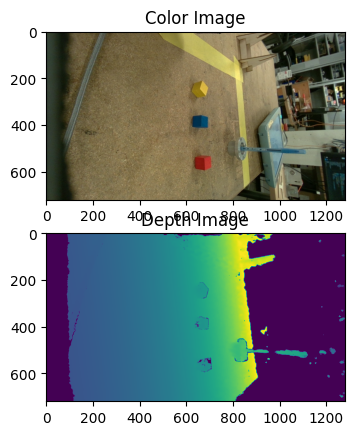

Masks


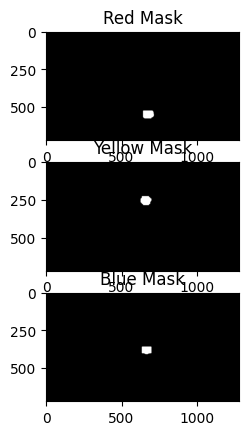

[(2721, PointCloud with 2721 points.)]
[(3239, PointCloud with 3239 points.)]
[(2522, PointCloud with 2522 points.), (28, PointCloud with 28 points.)]


In [13]:
urPose = robot.get_tcp_pose()
blocks = detector.getBlocksFromImages(colorImage,depthImage,urPose,display = True)

In [14]:
print( dir( blocks[0] ) )

for blok in blocks:
    print( blok.worldFrameCoords )

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'blockAABB', 'blockOBB', 'blockPCD', 'camFrameCoords', 'clusterBlockPCD', 'getCenterInGripperFrame', 'getCenterInWorld', 'getGraspPoint', 'getWorldFrameVerticalInGripper', 'gripperFrameCoords', 'move', 'name', 'urPose', 'worldFrameCoords']
[[   -0.99695    0.059463    0.050583    -0.35901]
 [ -0.0021458     0.62682    -0.77916    -0.38728]
 [  -0.078038    -0.77689    -0.62478    -0.18237]
 [          0           0           0           1]]
[[   -0.99695    0.059463    0.050583     -0.2308]
 [ -0.0021458     0.62682    -0.77916    -0.39624]
 [  -0.078038    -0.77689    -0.62478    -0.19075]
 [          0           0           0           1]]
[[   

In [15]:
cam.stop()
robot.stop()

RTDEControlInterface: RTDE control script is not running!
RTDEControlInterface: RTDE control script is not running!
